## Modelo 1: Regresión Logística

Librerías 

In [49]:
##Librerias
import pandas as pd
from sklearn.preprocessing import StandardScaler 

## Modelling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score
import statsmodels.api as sm


## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, roc_auc_score


Variables a usar

In [21]:
#variables categoricas dummizadas
v_cat=pd.read_csv("/Users/karenperez/Desktop/Analitica_3_Proyecto_1/v_cat.csv", sep=",")
#variables numéricas naturales - sin escalar
v_num=pd.read_csv("/Users/karenperez/Desktop/Analitica_3_Proyecto_1/v_num.csv", sep=",")


In [22]:
#Rectificación dummies
v_cat

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,Department_Human Resources,Department_Research & Development,Department_Sales,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,...,JobSatisfaction_1.0,JobSatisfaction_2.0,JobSatisfaction_3.0,JobSatisfaction_4.0,WorkLifeBalance_1.0,WorkLifeBalance_2.0,WorkLifeBalance_3.0,WorkLifeBalance_4.0,Education_2,Education_5
0,False,False,False,False,True,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
1,False,True,False,True,False,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
2,False,True,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
3,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
4,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,False,False,False,True,False,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
4304,False,False,False,False,True,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,False
4305,False,False,False,False,True,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4306,False,False,False,False,True,True,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


Escalar variables numéricas - 

In [23]:
# Ajustar el scaler a las variables numéricas y transformarlas
import pandas as pd
from sklearn.preprocessing import StandardScaler

def escalar_datos(v_num):
    escalador = StandardScaler()
    
    # Ajustar y transformar las columnas numéricas del DataFrame
    v_num_esc = escalador.fit_transform(v_num)
    
    # Convertir el resultado a un DataFrame con las mismas columnas
    v_num_esc_df = pd.DataFrame(v_num_esc, columns=v_num.columns, index=v_num.index)
    
    return v_num_esc_df

# Ejemplo de uso:
# v_num_esc = escalar_datos(v_num)
# print(v_num_esc)


In [25]:
v_num_esc=escalar_datos(v_num)
v_num_esc

,Age,DistanceFromHome,MonthlyIncome,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,1.539396,-0.394825,1.405220,2.483743,-0.980679,-0.677540
1,-0.648748,0.099337,-0.492641,0.157664,-0.329864,-0.368046
2,-0.539341,0.964121,2.725878,-0.617696,-0.329864,-0.677540
3,0.117102,-0.888987,0.385813,1.708383,0.158247,1.488922
4,-0.539341,0.099337,-0.885310,-0.617696,-0.167160,-0.677540
...,...,...,...,...,...,...
4303,-0.867563,-0.271285,-0.919751,-0.617696,-0.492568,-0.677540
4304,-0.429934,0.222878,0.134735,-0.617696,-0.329864,-0.677540
4305,-0.429934,-1.012528,-0.288973,-0.617696,0.320951,-0.368046
4306,-0.539341,1.705365,-0.858522,-0.617696,-0.655272,-0.368046


Concatenación de ambos dataframes de cada tipo de variable

In [26]:
df_retiros = pd.concat([v_num_esc, v_cat], axis=1)
df_retiros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4308 non-null   float64
 1   DistanceFromHome                   4308 non-null   float64
 2   MonthlyIncome                      4308 non-null   float64
 3   TrainingTimesLastYear              4308 non-null   float64
 4   YearsAtCompany                     4308 non-null   float64
 5   YearsSinceLastPromotion            4308 non-null   float64
 6   BusinessTravel_Non-Travel          4308 non-null   bool   
 7   BusinessTravel_Travel_Frequently   4308 non-null   bool   
 8   Department_Human Resources         4308 non-null   bool   
 9   Department_Research & Development  4308 non-null   bool   
 10  Department_Sales                   4308 non-null   bool   
 11  JobRole_Healthcare Representative  4308 non-null   bool 

In [27]:
df_retiros

,Age,DistanceFromHome,MonthlyIncome,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,Department_Human Resources,Department_Research & Development,...,JobSatisfaction_1.0,JobSatisfaction_2.0,JobSatisfaction_3.0,JobSatisfaction_4.0,WorkLifeBalance_1.0,WorkLifeBalance_2.0,WorkLifeBalance_3.0,WorkLifeBalance_4.0,Education_2,Education_5
0,1.539396,-0.394825,1.405220,2.483743,-0.980679,-0.677540,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
1,-0.648748,0.099337,-0.492641,0.157664,-0.329864,-0.368046,False,True,False,True,...,False,True,False,False,False,False,False,True,False,False
2,-0.539341,0.964121,2.725878,-0.617696,-0.329864,-0.677540,False,True,False,True,...,False,True,False,False,True,False,False,False,False,False
3,0.117102,-0.888987,0.385813,1.708383,0.158247,1.488922,True,False,False,True,...,False,False,False,True,False,False,True,False,False,True
4,-0.539341,0.099337,-0.885310,-0.617696,-0.167160,-0.677540,False,False,False,True,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,-0.867563,-0.271285,-0.919751,-0.617696,-0.492568,-0.677540,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
4304,-0.429934,0.222878,0.134735,-0.617696,-0.329864,-0.677540,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
4305,-0.429934,-1.012528,-0.288973,-0.617696,0.320951,-0.368046,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4306,-0.539341,1.705365,-0.858522,-0.617696,-0.655272,-0.368046,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


División Train/Test

In [31]:
df_2016=pd.read_csv("/Users/karenperez/Desktop/Analitica_3_Proyecto_1/processed_data_2015.csv", sep=",")

In [32]:
x=df_retiros
y=df_2016["renuncia2016"]

In [42]:
y

0       0
1       1
2       0
3       0
4       0
       ..
4303    0
4304    0
4305    0
4306    0
4307    0
Name: renuncia2016, Length: 4308, dtype: int64

In [35]:
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size=0.30, random_state=123) #Se dividirá en 30% test y 70% entrenamiento

Aplicación de algoritmo: Para este caso se debe usar un modelo de regresión logística, teniendo en cuenta que el problema a tratar es uno de clasificación (contamos con dos clases 1 y 0)

In [37]:
model = LogisticRegression()
model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

Predicción

In [43]:
print(y_pred_test[:100]) #impimir 100 primeras predicciones 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Evaluación del modelo 1: Sin balanceo de clases

[[2594   15]
 [ 390   16]]


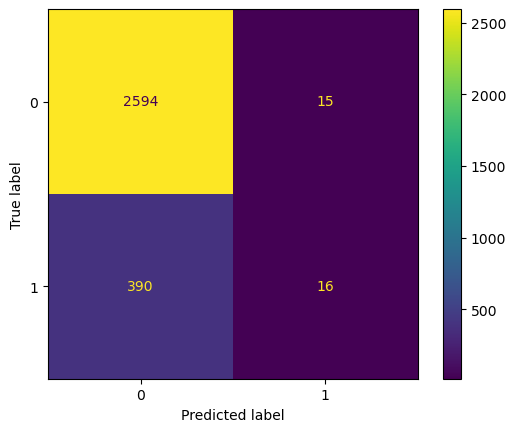

In [45]:
#Matriz de confusión para train-entrenamiento
# Matriz de confusión:
cm_train = confusion_matrix(y_train, y_pred_train, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,display_labels=model.classes_)
disp.plot();
print(cm_train)

In [47]:
#Métricas de desempeño train - entrenamiento
TP=cm_train[0,0]
FP=cm_train[1,0]
FN=cm_train[0,1]
TN=cm_train[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.8693029490616622
El Recall (Sensibilidad) es de): 0.9942506707550786
F1-score es: 0.07777777777777778


[[1120    8]
 [ 158    7]]


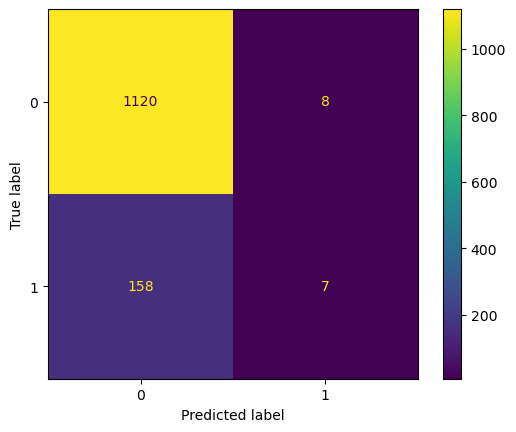

In [46]:
# Matriz de confusión para test-evaluación
cm_test = confusion_matrix(y_test, y_pred_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=model.classes_)
disp.plot();
print(cm_test)

In [48]:
TP=cm_test[0,0]
FP=cm_test[1,0]
FN=cm_test[0,1]
TN=cm_test[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.8763693270735524
El Recall (Sensibilidad) es de): 0.9929078014184397
F1-score es: 0.07777777777777778


Evaluación del modelo 1: Con balanceo de clases

[[768 360]
 [ 59 106]]


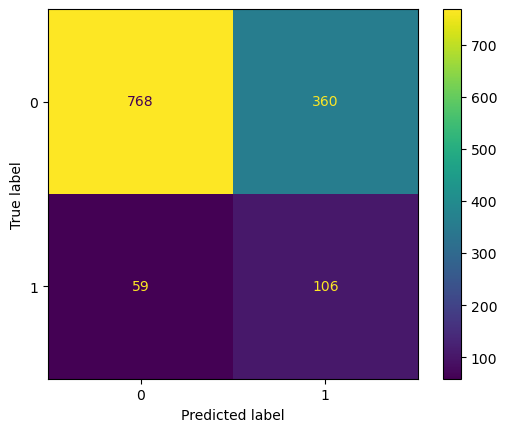

In [51]:
# Entrenar modelo
model_01 = LogisticRegression(random_state=123, class_weight="balanced") # definir el modelo
model_01.fit(x_train,y_train) # entrenar el modelo
y_pred_test_01 = model_01.predict(x_test) # predecir

# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred_test_01, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();
print(cm)

In [52]:
TP=cm[0,0]
FP=cm[1,0]
FN=cm[0,1]
TN=cm[1,1]

print(f'La precisión es del: {TP/(TP+FP)}')
print(f'El Recall (Sensibilidad) es de): {TP/(TP+FN)}')
print(f'F1-score es:', f1_score(y_test, y_pred_test, average='binary'))

La precisión es del: 0.9286577992744861
El Recall (Sensibilidad) es de): 0.6808510638297872
F1-score es: 0.07777777777777778
